# Import all kind of stuff

In [1]:
import numpy as np

from matplotlib.markers import MarkerStyle
from matplotlib.lines import Line2D

import superconductivity.api as sc

from superconductivity.api import G_0_muS
from superconductivity.api import NDArray64

from IPython import get_ipython

_ip = get_ipython()
if _ip is not None:
    _ip.run_line_magic("reload_ext", "autoreload")
    _ip.run_line_magic("autoreload", "2")

    _ip.run_line_magic(
        "config",
        "InlineBackend.print_figure_kwargs = {'bbox_inches': None, 'pad_inches': 0.0}",
    )
    _ip.run_line_magic("config", 'InlineBackend.figure_format = "retina"')  # or "png"
    _ip.run_line_magic(
        "config", "InlineBackend.rc = {'figure.dpi': 300}"
    )  # choose a value you like

INFO:2026-01-28 15:03:06,704:jax._src.xla_bridge:812: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/Users/oliver/.pyenv/versions/3.13.3/lib/libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Users/oliver/.pyenv/versions/3.13.3/lib/libtpu.so' (no such file), '/opt/homebrew/lib/libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file)
Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/Users/oliver/.pyenv/versions/3.13.3/lib/libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Users/oliver/.pyenv/versions/3.13.3/lib/libtpu.so' (no suc

# gap-suppression

In [2]:
def Delta_of_T(T: NDArray64, T_C: float = 1.0, Delta_0: float = 1.0):
    Delta = np.where(T != 0, Delta_0 * np.tanh(1.74 * np.sqrt(T_C / T - 1)), 1.0)
    return Delta


T = np.linspace(0, 1, 101)

Delta = Delta_of_T(T)

/var/folders/kc/8fnzl3f94vxgl8w4wm3wfvk80000gn/T/ipykernel_56698/1040264521.py:2: RuntimeWarning: divide by zero encountered in divide
  Delta = np.where(T != 0, Delta_0 * np.tanh(1.74 * np.sqrt(T_C / T - 1)), 1.0)


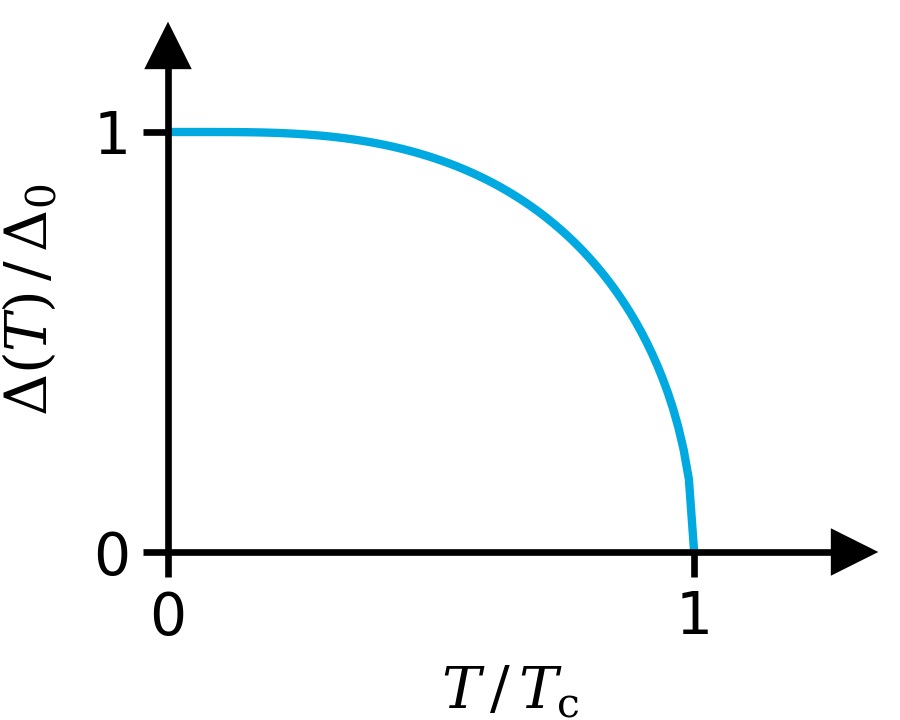

In [3]:
fig, ax = sc.get_figure(figsize=(1.5, 1.2))

ax.plot(T, Delta, color=sc.seeblau100)

ax.set_xlim(0, 1.3)
ax.set_xticks([0, 1])
ax.set_ylim(0, 1.2)
ax.set_yticks([0, 1])

xlabel = "$T\\,/\\,T_\\mathrm{c}$"
ylabel = "$\\Delta(T)\\,/\\,\\Delta_0$"
title = "theory/micro/gap"

sc.theory_layout(fig, ax, title, xlabel, ylabel)

# dos-fermi

In [4]:
Delta_meV = 0.180
E_meV = np.linspace(-2.5 * Delta_meV, 2.5 * Delta_meV, 1001)
gammas_Delta = np.array([0, 1, 2.5, 5]) * 1e-2

Ns = np.full((gammas_Delta.shape[0], E_meV.shape[0]), np.nan)
for i, gamma in enumerate(gammas_Delta):
    Ns[i, :] = sc.get_dos(
        E_meV=E_meV,
        Delta_meV=Delta_meV,
        gamma_meV=gamma * Delta_meV,
    )

/Users/oliver/Documents/superconductivity/superconductivity/models/bcs_np.py:148: RuntimeWarning: divide by zero encountered in divide
  dos = np.divide(E_complex_meV, denom)
/Users/oliver/Documents/superconductivity/superconductivity/models/bcs_np.py:148: RuntimeWarning: invalid value encountered in divide
  dos = np.divide(E_complex_meV, denom)


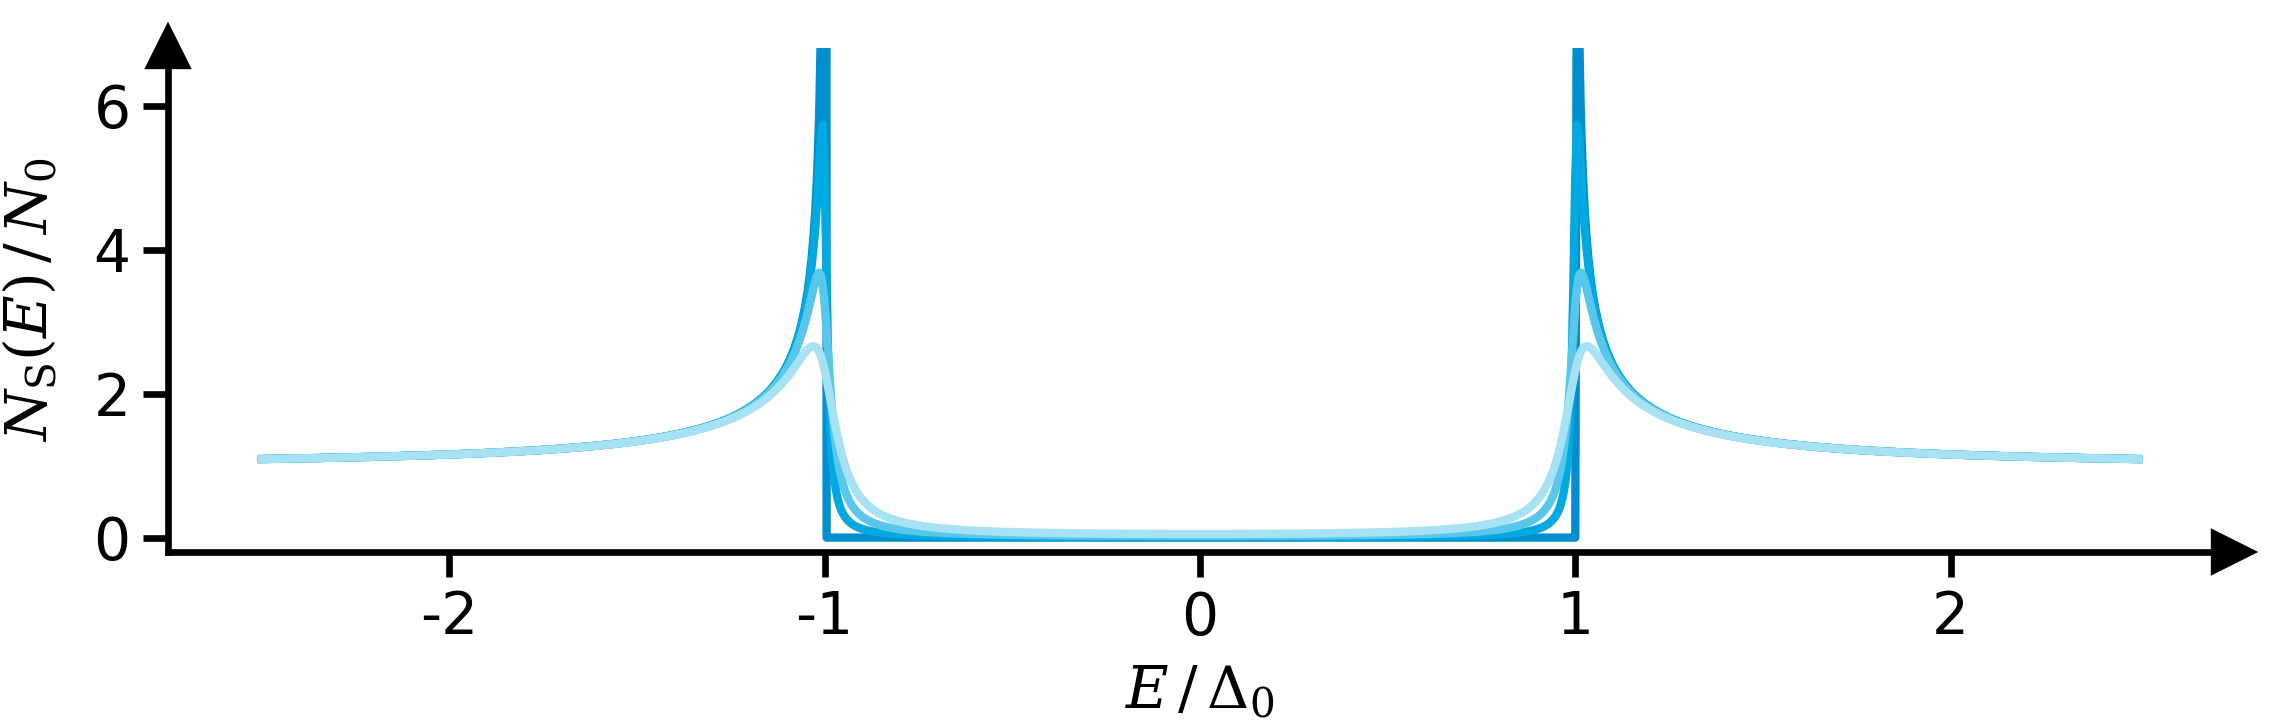

In [5]:
fig, ax = sc.get_figure(figsize=(3.8, 1.2))

for i, Gamma in enumerate(gammas_Delta):
    ax.plot(
        E_meV / Delta_meV,
        Ns[i, :],
        color=sc.seeblau[i],
        zorder=i,
        label=f"{Gamma*1e2}e-2",
    )

ax.set_ylim(-0.2, 6.8)
ax.set_yticks([0, 2, 4, 6])
ax.set_xticks([-2, -1, 0, 1, 2])

xlabel = "$E\\,/\\,\\Delta_0$"
ylabel = "$N_\\mathrm{S}(E)\\,/\\,N_0$"
title = "theory/micro/dos"

sc.theory_layout(fig, ax, title, xlabel, ylabel)

In [6]:
Delta_meV = 0.180
E_meV = np.linspace(-1.5 * Delta_meV, 1.5 * Delta_meV, 1501)
Ts_TC = np.array([0, 0.3, 0.6, 0.9])
T_C = Delta_meV / (1.764 * sc.k_B_meV)

fs = np.full((Ts_TC.shape[0], E_meV.shape[0]), np.nan)
for i, T in enumerate(Ts_TC):
    fs[i, :] = sc.get_f(E_meV=E_meV, T_K=T * T_C)

dfs = -np.gradient(fs, E_meV / Delta_meV, axis=1)
dfs[0, :] = np.zeros_like(E_meV)
dfs[0, 750] = 10

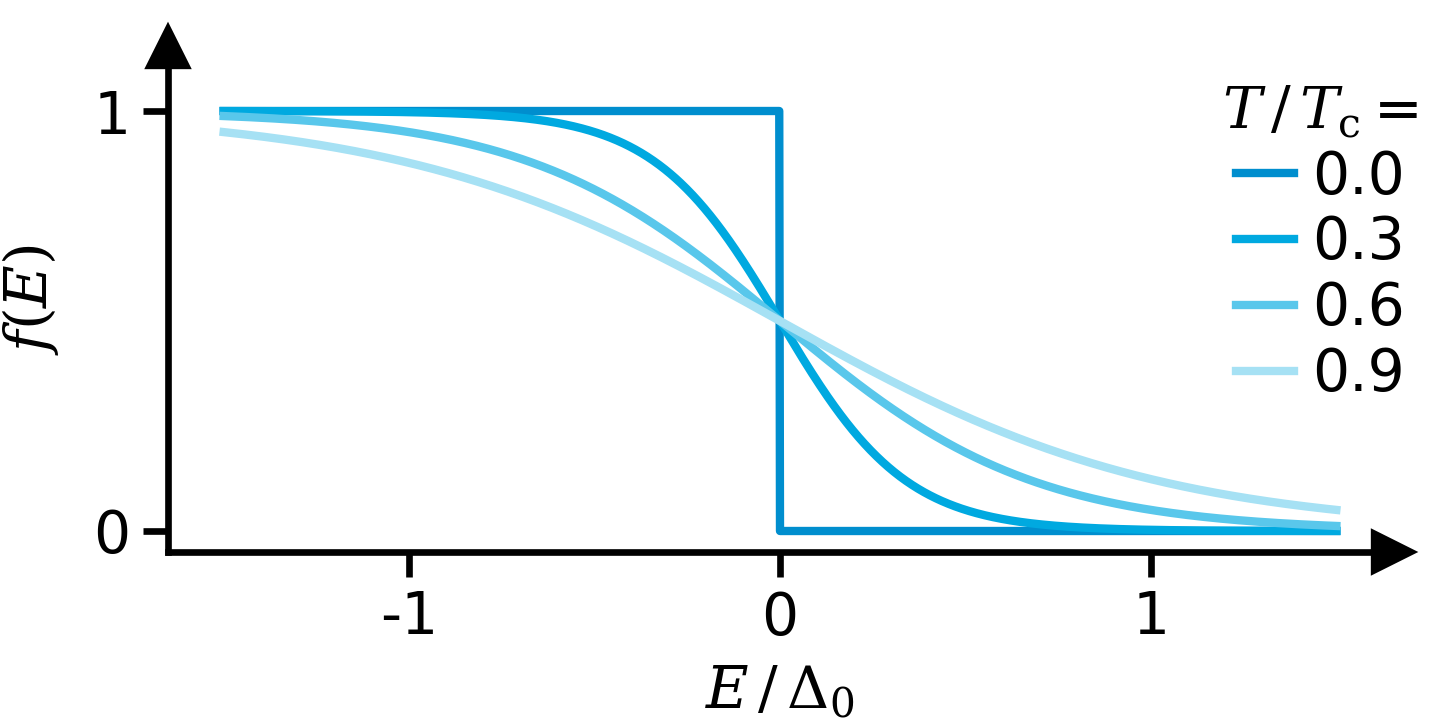

In [7]:
fig, ax = sc.get_figure(figsize=(2.4, 1.2))

for i, T in enumerate(Ts_TC):
    ax.plot(
        E_meV / Delta_meV,
        fs[i, :],
        zorder=i,
        color=sc.seeblau[i],
        label=f"{T:1.1f}",
    )

ax.legend(
    title="$T\\,/\\,T_\\mathrm{c} = $",
    handlelength=1.0,
    loc="upper right",
    frameon=False,
    fontsize=7,
    title_fontsize=7,
    bbox_to_anchor=(1.05, 1.0),
    # bbox_to_anchor=(1.0, 1.15),
    borderpad=0.1,  # reduces padding inside the legend box
    labelspacing=0.15,  # reduces vertical spacing between items
    handletextpad=0.3,  # reduces spacing between line and label
)


ax.set_ylim(-0.05, 1.15)
ax.set_yticks([0, 1])
ax.set_xticks([-1, 0, 1])

xlabel = "$E\\,/\\,\\Delta_0$"
ylabel = "$f(E)$"
title = "theory/micro/fermi"

sc.theory_layout(fig, ax, title, xlabel, ylabel)

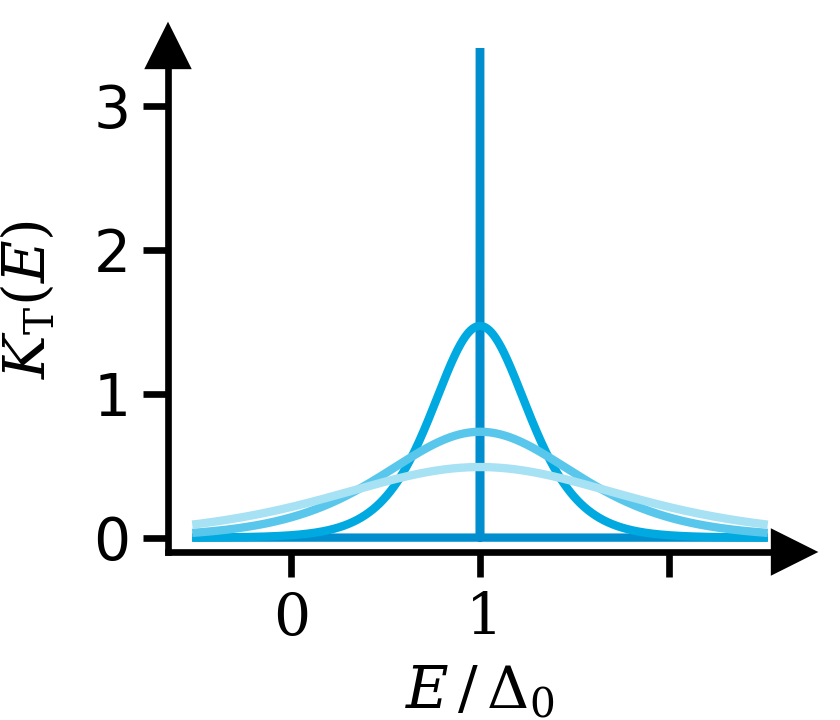

In [8]:
fig, ax = sc.get_figure(figsize=(1.4, 1.2))

for i, T in enumerate(Ts_TC):
    ax.plot(
        E_meV / Delta_meV,
        dfs[i, :],
        color=sc.seeblau[i],
        zorder=i - 10,
        label=f"{T:1.1f}",
    )

ax.set_ylim(-0.1, 3.4)
ax.set_yticks([0, 1, 2, 3])
ax.set_xticks([-1, 0, 1], labels=["$0$", "$1$", " "])

xlabel = "$E\\,/\\,\\Delta_0$"
ylabel = "$K_\\mathrm{T}(E)$"
title = "theory/micro/fermi-kernel"

sc.theory_layout(fig, ax, title, xlabel, ylabel)

# tunnel-current

Attention: don't use $G_0$ yet. its not introduced. stick to $G_N$

In [9]:
# generate data
Delta_meV = 0.189
V_mV = np.linspace(0, 2.5 * Delta_meV, 601)  # mV
G_N = 1
T_TC_NS = np.array([0, 0.1, 0.2, 0.4])
# T_TC_SS = np.array([0, 0.1, 0.2, 0.4])
T_TC_SS = np.array([0, 0.4, 0.5, 0.6])
T_C_K = 1.2
gamma_Delta = np.array([0, 1, 2.5, 5.0]) * 1e-2
gamma_Delta = np.array([0, 2.5, 5, 7.5]) * 1e-2

I_NN = G_N * sc.G_0_muS * V_mV  # nA
dIdV_NN = np.gradient(I_NN, V_mV) / sc.G_0_muS

I_NS_T = np.full((T_TC_NS.shape[0], V_mV.shape[0]), np.nan)
I_SS_T = np.full((T_TC_SS.shape[0], V_mV.shape[0]), np.nan)
I_NS_Gamma = np.full((gamma_Delta.shape[0], V_mV.shape[0]), np.nan)
I_SS_Gamma = np.full((gamma_Delta.shape[0], V_mV.shape[0]), np.nan)

for i, T in enumerate(T_TC_NS):
    I_NS_T[i, :] = sc.get_I_bcs_nA(
        V_mV=V_mV,
        G_N=G_N,
        Delta_meV=(0.0, Delta_meV),
        T_K=T * T_C_K,
        gamma_meV=0.0,
    )
for i, T in enumerate(T_TC_SS):
    I_SS_T[i, :] = sc.get_I_bcs_nA(
        V_mV=V_mV,
        G_N=G_N,
        Delta_meV=(Delta_meV, Delta_meV),
        T_K=T * T_C_K,
        gamma_meV=0.0,
    )

for i, gamma in enumerate(gamma_Delta):
    I_NS_Gamma[i, :] = sc.get_I_bcs_nA(
        V_mV=V_mV,
        G_N=G_N,
        Delta_meV=(0.0, Delta_meV),
        T_K=0.0,
        gamma_meV=gamma * Delta_meV,
    )
    I_SS_Gamma[i, :] = sc.get_I_bcs_nA(
        V_mV=V_mV,
        G_N=G_N,
        Delta_meV=(Delta_meV, Delta_meV),
        T_K=0.0,
        gamma_meV=gamma * Delta_meV,
    )

dIdV_NS_T = np.gradient(I_NS_T, V_mV, axis=1) / G_0_muS
dIdV_SS_T = np.gradient(I_SS_T, V_mV, axis=1) / G_0_muS
dIdV_NS_Gamma = np.gradient(I_NS_Gamma, V_mV, axis=1) / G_0_muS
dIdV_SS_Gamma = np.gradient(I_SS_Gamma, V_mV, axis=1) / G_0_muS

I_NS_T /= Delta_meV * G_0_muS
I_SS_T /= Delta_meV * G_0_muS
I_NS_Gamma /= Delta_meV * G_0_muS
I_SS_Gamma /= Delta_meV * G_0_muS

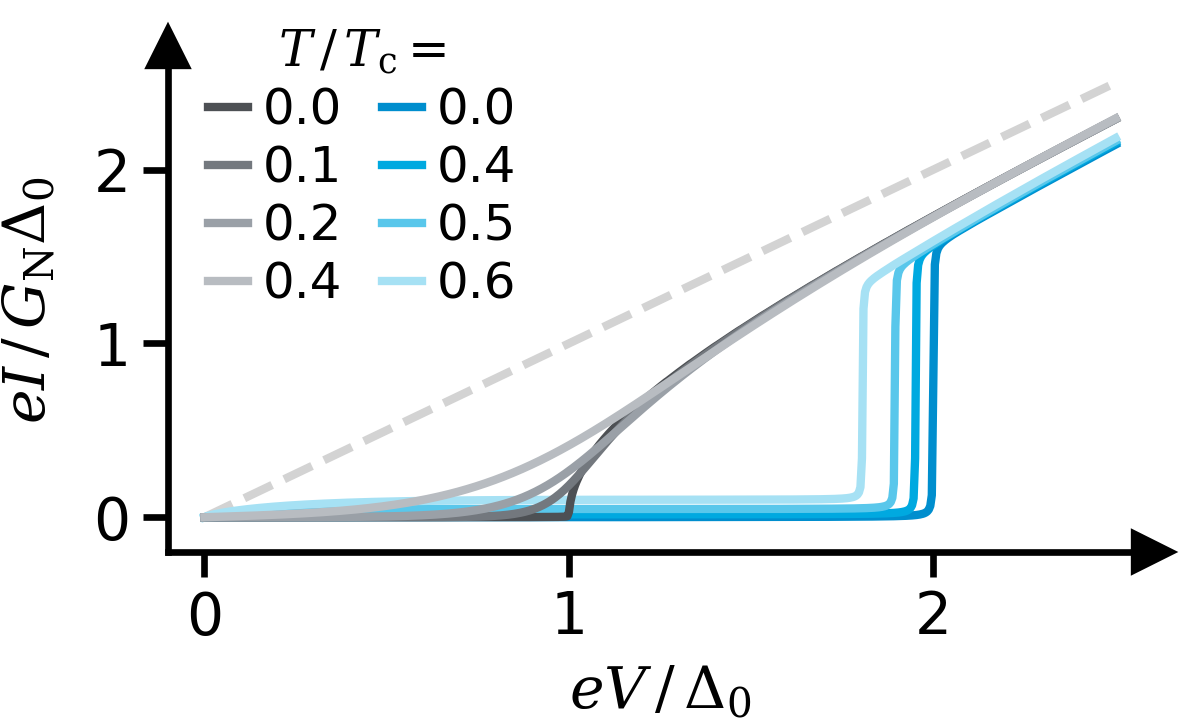

In [10]:
fig, ax = sc.get_figure(figsize=(2.0, 1.2))

ax.plot(
    V_mV / Delta_meV,
    V_mV / Delta_meV,
    linestyle="--",
    color="lightgrey",
    zorder=0,
)

for i, T in enumerate(T_TC_NS):
    # NS
    ax.plot(
        V_mV / Delta_meV,
        I_NS_T[i, :],
        color=sc.seegrau[i],
        zorder=i + 10,
        label=f"{T:1.1f}",
    )

for i, T in enumerate(T_TC_SS):
    # SS
    ax.plot(
        V_mV / Delta_meV,
        I_SS_T[i, :],
        color=sc.seeblau[i],
        zorder=i,
        label=f"{T:1.1f}",
    )

ax.legend(
    title="$T\\,/\\,T_\\mathrm{c} = $",
    handlelength=0.8,
    loc="upper left",
    frameon=False,
    fontsize=6,
    title_fontsize=6,
    ncols=2,
    columnspacing=0.8,
    borderpad=0.1,  # reduces padding inside the legend box
    labelspacing=0.2,  # reduces vertical spacing between items
    handletextpad=0.3,  # reduces spacing between line and label
    bbox_to_anchor=(0.01, 1.1),
)

ax.set_xlim(-0.1, 2.6)
ax.set_ylim(-0.2, 2.7)
ax.set_yticks([0, 1, 2])
ax.set_xticks([0, 1, 2])

xlabel = "$eV\\,/\\,\\Delta_0$"
ylabel = "$eI\\,/\\,G_\\mathrm{N}\\Delta_0$"
title = "theory/micro/tunnel-iv-T"

sc.theory_layout(fig, ax, title, xlabel, ylabel)

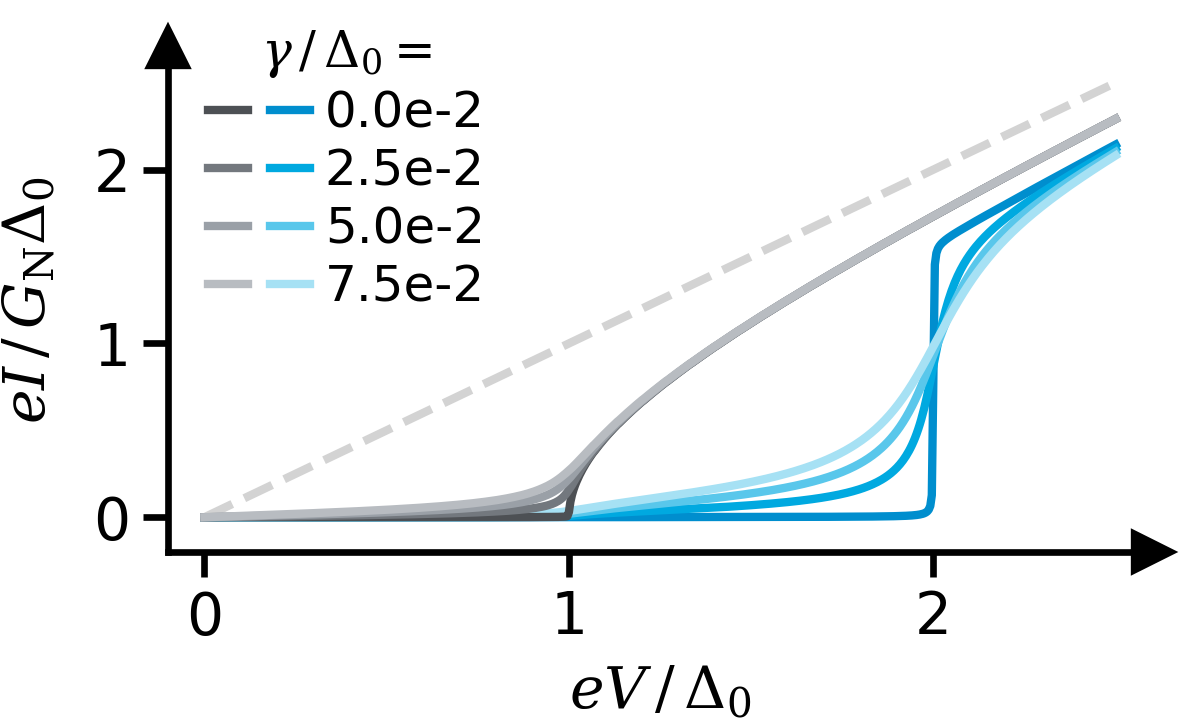

In [11]:
fig, ax = sc.get_figure(figsize=(2.0, 1.2))

ax.plot(
    V_mV / Delta_meV,
    V_mV / Delta_meV,
    linestyle="--",
    color="lightgrey",
    zorder=0,
)

for i, gamma in enumerate(gamma_Delta):
    # NS
    ax.plot(
        V_mV / Delta_meV,
        I_NS_Gamma[i, :],
        color=sc.seegrau[i],
        zorder=i + 10,
        label="$\\,$",
    )

for i, gamma in enumerate(gamma_Delta):
    # SS
    ax.plot(
        V_mV / Delta_meV,
        I_SS_Gamma[i, :],
        color=sc.seeblau[i],
        zorder=i,
        label=f"{gamma*1e2:.1f}e-2",
    )

ax.set_xlim(-0.1, 2.6)
ax.set_ylim(-0.2, 2.7)
ax.set_yticks([0, 1, 2])
ax.set_xticks([0, 1, 2])

ax.legend(
    title="$\\gamma\\,/\\,\\Delta_0 = $",
    handlelength=0.8,
    loc="upper left",
    frameon=False,
    fontsize=6,
    title_fontsize=6,
    ncols=2,
    columnspacing=0.1,
    borderpad=0.1,  # reduces padding inside the legend box
    labelspacing=0.2,  # reduces vertical spacing between items
    handletextpad=0.3,  # reduces spacing between line and label
    bbox_to_anchor=(0.01, 1.1),
)

xlabel = "$eV\\,/\\,\\Delta_0$"
ylabel = "$eI\\,/\\,G_\\mathrm{N}\\Delta_0$"
title = "theory/micro/tunnel-iv-gamma"

sc.theory_layout(fig, ax, title, xlabel, ylabel)

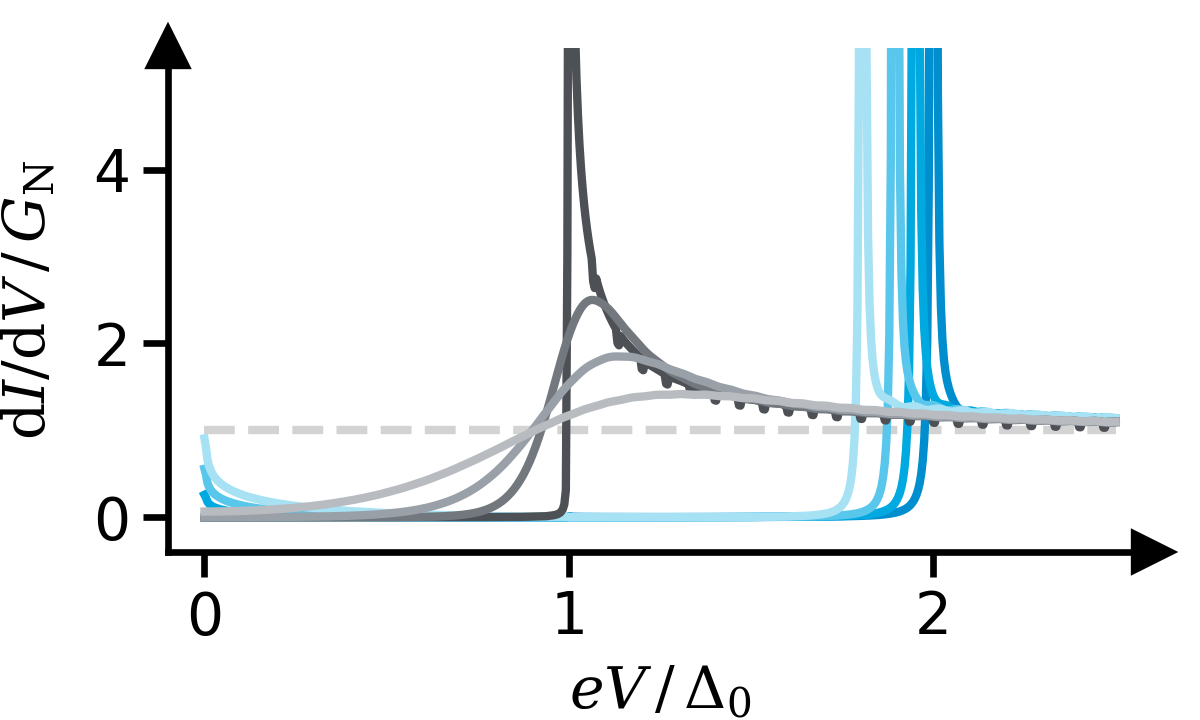

In [12]:
fig, ax = sc.get_figure(figsize=(2.0, 1.2))

ax.plot(
    V_mV / Delta_meV,
    np.ones_like(V_mV / Delta_meV),
    linestyle="--",
    color="lightgrey",
    zorder=0,
)

for i, T in enumerate(T_TC_NS):
    # NS
    ax.plot(
        V_mV / Delta_meV,
        dIdV_NS_T[i, :],
        color=sc.seegrau[i],
        zorder=i + 100,
        label=f"{T:1.1f}",
    )

for i, T in enumerate(T_TC_SS):
    # SS
    ax.plot(
        V_mV / Delta_meV,
        dIdV_SS_T[i, :],
        color=sc.seeblau[i],
        zorder=i + 10,
        label=f"{T:1.1f}",
    )

ax.set_xlim(-0.1, 2.6)
ax.set_xticks([0, 1, 2])
ax.set_ylim(-0.4, 5.4)
ax.set_yticks([0, 2, 4])

xlabel = "$eV\\,/\\,\\Delta_0$"
ylabel = "$\\mathrm{d}I/\\mathrm{d}V\\,/\\,G_\\mathrm{N}$"
title = "theory/micro/tunnel-didv-T"

sc.theory_layout(fig, ax, title, xlabel, ylabel)

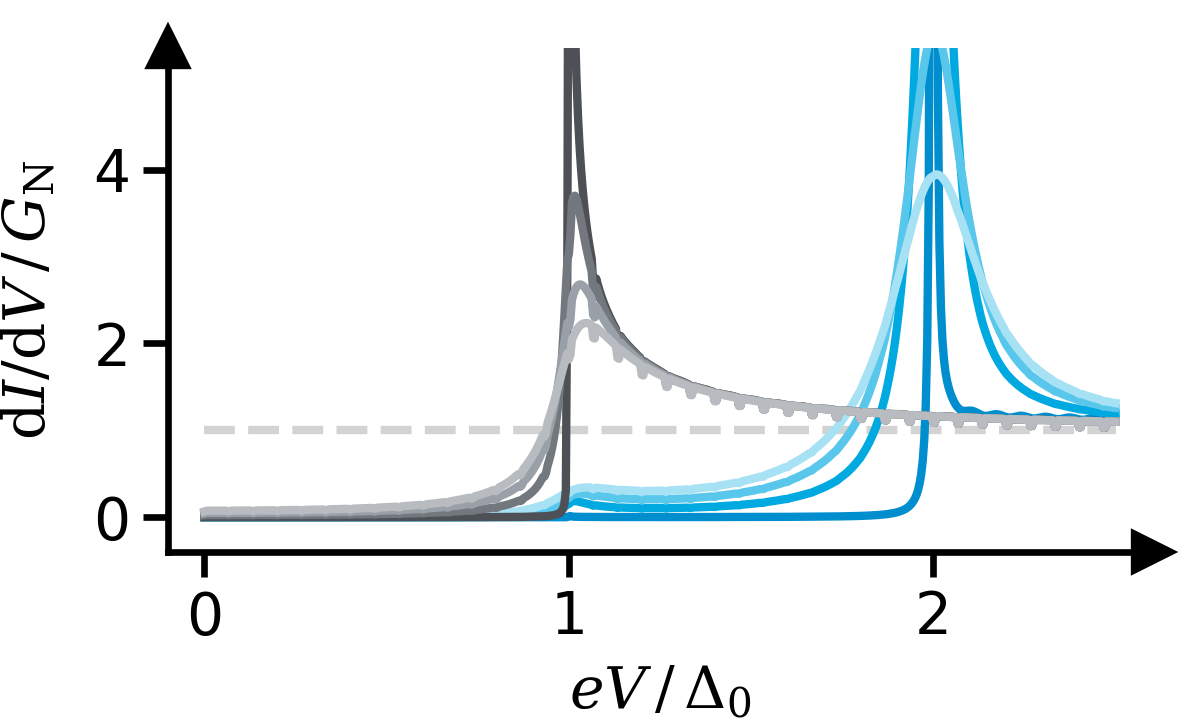

In [13]:
fig, ax = sc.get_figure(figsize=(2.0, 1.2))

ax.plot(
    V_mV / Delta_meV,
    np.ones_like(V_mV / Delta_meV),
    linestyle="--",
    color="lightgrey",
    zorder=0,
)

for i, gamma in enumerate(gamma_Delta):
    # NS
    ax.plot(
        V_mV / Delta_meV,
        dIdV_NS_Gamma[i, :],
        color=sc.seegrau[i],
        zorder=i + 10,
        label="$\\,$",
    )

for i, gamma in enumerate(gamma_Delta):
    # SS
    ax.plot(
        V_mV / Delta_meV,
        dIdV_SS_Gamma[i, :],
        color=sc.seeblau[i],
        zorder=i,
    )

ax.set_xlim(-0.1, 2.6)
ax.set_xticks([0, 1, 2])
ax.set_ylim(-0.4, 5.4)
ax.set_yticks([0, 2, 4])

xlabel = "$eV\\,/\\,\\Delta_0$"
ylabel = "$\\mathrm{d}I/\\mathrm{d}V\\,/\\,G_\\mathrm{N}$"
title = "theory/micro/tunnel-didv-gamma"

sc.theory_layout(fig, ax, title, xlabel, ylabel)

# PAT

In [18]:
# generate data
Delta_meV = 0.180
V_mV = np.linspace(0, 2.5, 501) * Delta_meV  # mV
A_mV = np.array([0, 0.1, 0.2]) * Delta_meV  # mV
A_mV = np.array([0, 0.3, 0.6]) * Delta_meV  # mV

G_N = 1
T_K = 0.0
gamma_meV = 0.0
nu_GHz = 10.0

N_S = np.full((A_mV.shape[0], V_mV.shape[0]), np.nan)
I_NS = np.full((A_mV.shape[0], V_mV.shape[0]), np.nan)
I_SS = np.full((A_mV.shape[0], V_mV.shape[0]), np.nan)

N_S_0 = sc.get_dos(E_meV=V_mV, Delta_meV=Delta_meV, gamma_meV=gamma_meV)

I_NS_0 = sc.get_I_bcs_nA(
    V_mV=V_mV,
    G_N=G_N,
    Delta_meV=(0.0, Delta_meV),
    T_K=T_K,
    gamma_meV=gamma_meV,
)
I_SS_0 = sc.get_I_bcs_nA(
    V_mV=V_mV,
    G_N=G_N,
    Delta_meV=(Delta_meV, Delta_meV),
    T_K=T_K,
    gamma_meV=gamma_meV,
)

N_S = sc.get_I_pat_nA(A_mV=A_mV, V_mV=V_mV, I_nA=N_S_0, nu_GHz=nu_GHz)
I_NS = sc.get_I_pat_nA(A_mV=A_mV, V_mV=V_mV, I_nA=I_NS_0, nu_GHz=nu_GHz) / (
    G_0_muS * Delta_meV
)
I_SS = sc.get_I_pat_nA(A_mV=A_mV, V_mV=V_mV, I_nA=I_SS_0, nu_GHz=nu_GHz) / (
    G_0_muS * Delta_meV
)

dIdV_NS = np.gradient(I_NS, V_mV / Delta_meV, axis=1)
dIdV_SS = np.gradient(I_SS, V_mV / Delta_meV, axis=1)

/Users/oliver/Documents/superconductivity/superconductivity/models/bcs_np.py:148: RuntimeWarning: divide by zero encountered in divide
  dos = np.divide(E_complex_meV, denom)
/Users/oliver/Documents/superconductivity/superconductivity/models/bcs_np.py:148: RuntimeWarning: invalid value encountered in divide
  dos = np.divide(E_complex_meV, denom)


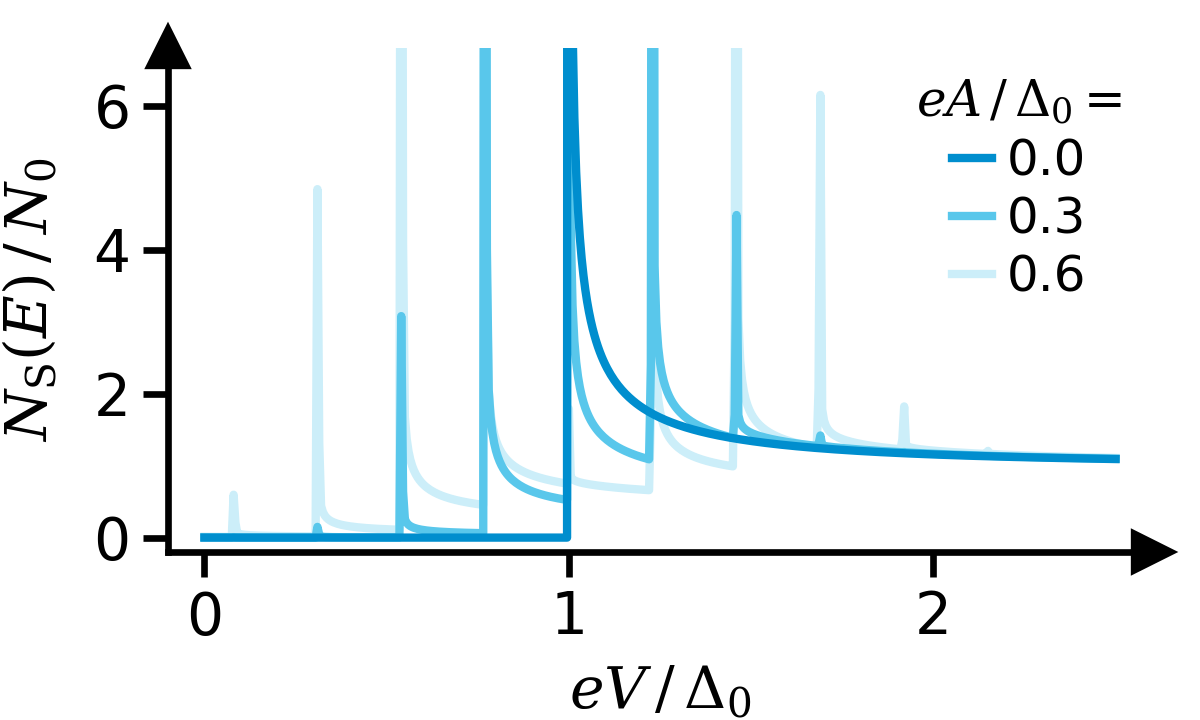

In [19]:
fig, ax = sc.get_figure(figsize=(2.0, 1.2))

for i, A in enumerate(A_mV):
    # NS
    ax.plot(
        V_mV / Delta_meV,
        N_S[i, :],
        color=sc.seeblau[i * 2],
        zorder=10 - i,
        label=f"{A/Delta_meV:1.1f}",
    )

ax.set_xlim(-0.1, 2.6)
ax.set_xticks([0, 1, 2])
ax.set_ylim(-0.2, 6.8)
ax.set_yticks([0, 2, 4, 6])

ax.legend(
    title="$eA\\,/\\,\\Delta_0 = $",
    handlelength=0.8,
    loc="upper right",
    frameon=False,
    fontsize=6,
    title_fontsize=6,
    ncols=1,
    columnspacing=0.1,
    borderpad=0.1,  # reduces padding inside the legend box
    labelspacing=0.2,  # reduces vertical spacing between items
    handletextpad=0.3,  # reduces spacing between line and label
    # bbox_to_anchor=(0.01, 1.1),
)

xlabel = "$eV\\,/\\,\\Delta_0$"
ylabel = "$N_\\mathrm{S}(E)\\,/\\,N_0$"
title = None

sc.theory_layout(fig, ax, title, xlabel, ylabel)

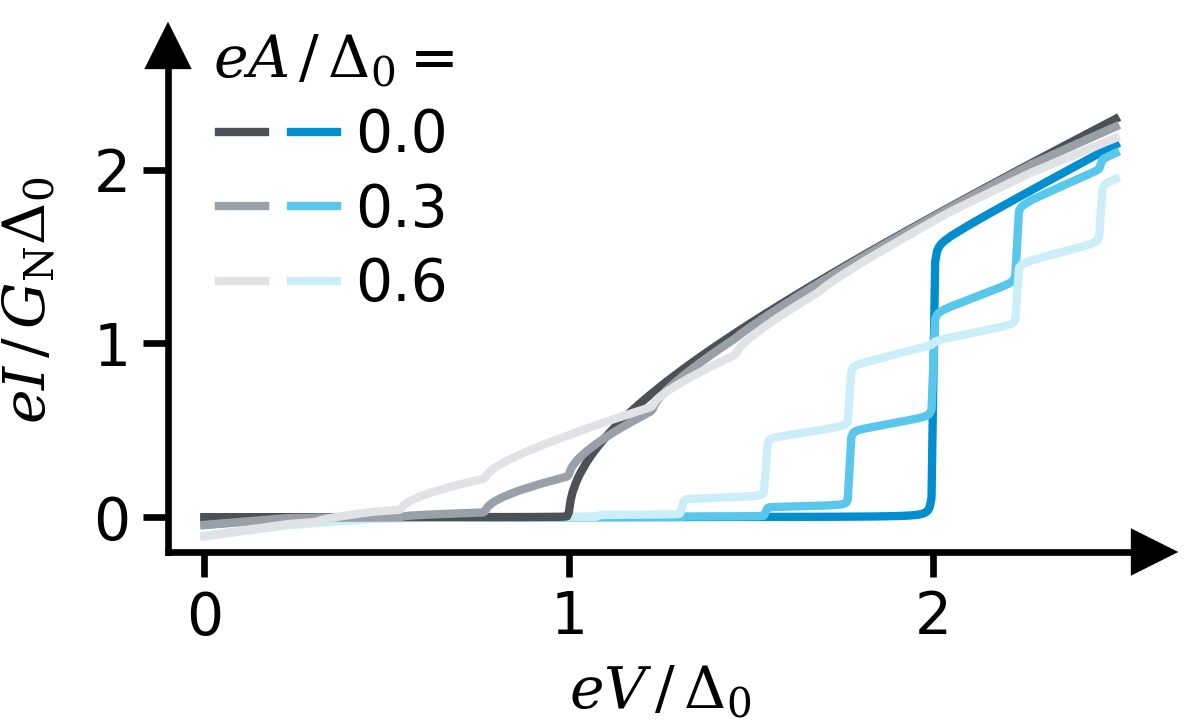

In [20]:
fig, ax = sc.get_figure(figsize=(2.0, 1.2))

for i, A in enumerate(A_mV):
    # NS
    ax.plot(
        V_mV / Delta_meV,
        I_NS[i, :],
        color=sc.seegrau[2 * i],
        zorder=i + 10,
        label="$\\,$",
    )

for i, A in enumerate(A_mV):
    # SS
    ax.plot(
        V_mV / Delta_meV,
        I_SS[i, :],
        color=sc.seeblau[2 * i],
        zorder=i,
        label=f"{A/Delta_meV:1.1f}",
    )

ax.set_xlim(-0.1, 2.6)
ax.set_ylim(-0.2, 2.7)
ax.set_yticks([0, 1, 2])
ax.set_xticks([0, 1, 2])

ax.legend(
    title="$eA\\,/\\,\\Delta_0 = $",
    handlelength=0.8,
    loc="upper left",
    frameon=False,
    fontsize=7,
    title_fontsize=7,
    ncols=2,
    columnspacing=0.1,
    borderpad=0.1,  # reduces padding inside the legend box
    labelspacing=0.3,  # reduces vertical spacing between items
    handletextpad=0.3,  # reduces spacing between line and label
    bbox_to_anchor=(0.01, 1.1),
)

xlabel = "$eV\\,/\\,\\Delta_0$"
ylabel = "$eI\\,/\\,G_\\mathrm{N}\\Delta_0$"
title = "theory/micro/pat-iv"

sc.theory_layout(fig, ax, title, xlabel, ylabel)

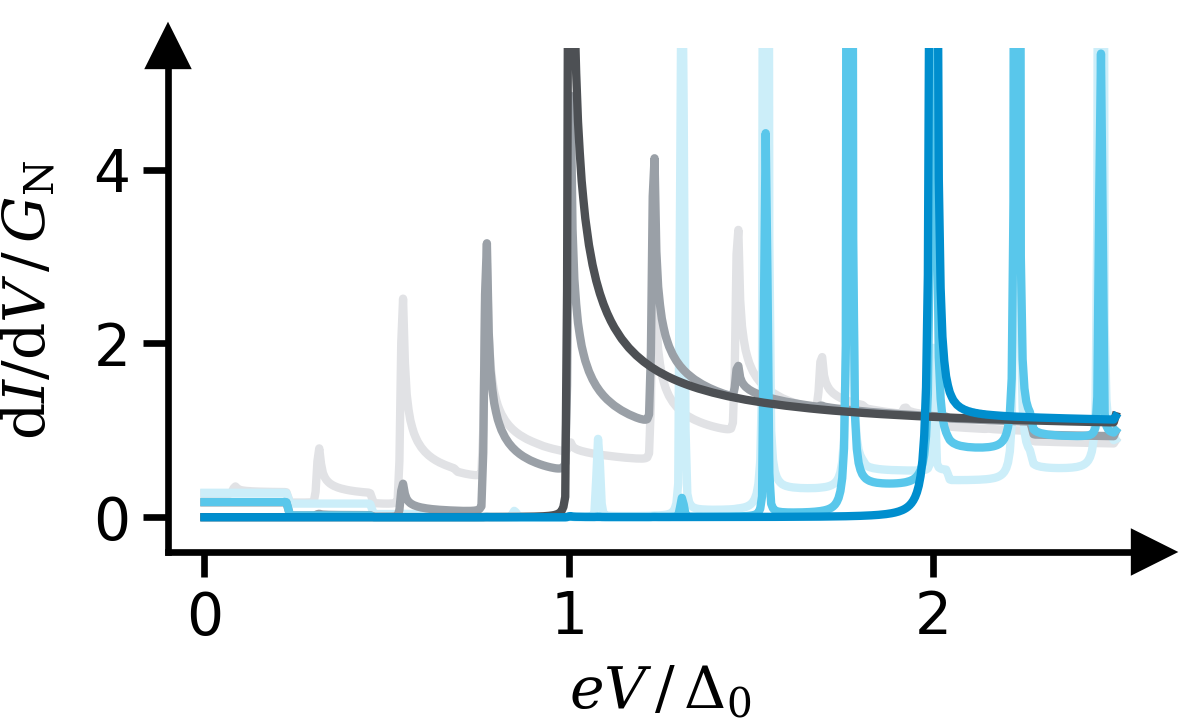

In [21]:
fig, ax = sc.get_figure(figsize=(2.0, 1.2))

for i, A in enumerate(A_mV):
    ax.plot(
        V_mV / Delta_meV,
        dIdV_NS[i, :],
        color=sc.seegrau[2 * i],
        zorder=10 - i,
    )
    ax.plot(
        V_mV / Delta_meV,
        dIdV_SS[i, :],
        color=sc.seeblau[2 * i],
        zorder=10 - i,
    )

ax.set_xlim(-0.1, 2.6)
ax.set_xticks([0, 1, 2])
ax.set_ylim(-0.4, 5.4)
ax.set_yticks([0, 2, 4])

xlabel = "$eV\\,/\\,\\Delta_0$"
ylabel = "$\\mathrm{d}I/\\mathrm{d}V\\,/\\,G_\\mathrm{N}$"
title = "theory/micro/pat-didv"

sc.theory_layout(fig, ax, title, xlabel, ylabel)